## A Convolutional Neural Network for a Dog Breed Identification App

In this notebook, I will develop an algorithm that could be used as part of a mobile or web app. The algorithm will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, just for fun it will provide an estimate of the dog breed that is most resembling. The image below displays potential sample output of the finished project.  

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, I have pieced together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  

## Table of Contents

* [Import Datasets](#step0) 
* [An Algorithm to Detects Humans](#step1) 
* [An Algorithm to Detects Dogs](#step2) 
* [CNN from Scratch to Classify Dog Breeds (Benchmark)](#step3) 
* [Transfer Learning to Classify Dog Breeds](#step4)  
* [An Algorithm to Determine Whether a Image Contains a Human, Dog, or Neither](#step5) 
* [Test the Algorithm on Sample Images](#step6)
* [Conclusion](#step7)

---
<a id='step0'></a>
## Import Datasets

### Import Dog Dataset

In the code cell below, I imported a dataset of dog images. I populated a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

**I downloaded the `dogImages` folder used in the code cell below from [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) and stored it in `data` folder.**

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dogImages/train')
valid_files, valid_targets = load_dataset('data/dogImages/valid')
test_files, test_targets = load_dataset('data/dogImages/test')

# load list of dog names
dog_names = [item[25:-1] for item in sorted(glob("data/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, I have imported a dataset of human images, where the file paths are stored in the numpy array `human_files`.

**I downloaded the `lfw` folder used in the code cell below from [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip) and stored it in `data` folder.**

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## An Algorithm to Detect Humans

I used OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). I have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, it is demonstrated as to how to use this detector to find human faces in a sample image.

Number of faces detected: 1


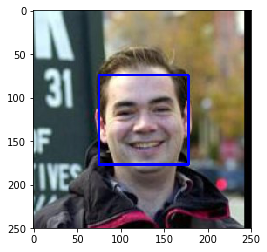

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function takes the grayscale image as a parameter and executes the classifier stored in `face_cascade`.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

This procedure is used in the function named `face_detector` in the code cell below that returns `True` if a human face is detected in an image and `False` otherwise. This function takes a string-valued file path to an image as input.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0

### Assess the Human Face Detector

In the code cell below, I extracted the file paths for the first 100 images from each of the datasets and stored them in the numpy arrays `human_files_short` and `dog_files_short`. These files were fed into face_detector function to assess its performance.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector function 
## on the images in human_files_short and dog_files_short.

percent_face_detected_human_files = np.sum([face_detector(file) for file in human_files_short])
percent_face_detected_dog_files = np.sum([face_detector(file) for file in dog_files_short])
#Since there are exactly 100 images in each file, the above code directly produces percentage.

print ("{}% of the first 100 images in human_files have a detected human face.".format(percent_face_detected_human_files))
print ("{}% of the first 100 images in dog_files have a detected human face.".format(percent_face_detected_dog_files))

98% of the first 100 images in human_files have a detected human face.
11% of the first 100 images in dog_files have a detected human face.


Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. However the `face_detector` function falls short of this goal, but still gives acceptable performance. As seen in the output of the above code block, the algorithm correctly detected human face in only 98% of the  images containing a human face, and it incorrectly detected a face in 11% of the images containing a dog.

---
<a id='step2'></a>
## An Algorithm to Detect Dogs

In this section, I will use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. The code below downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (refered to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since I am working with color images, each image has three channels.  Since I am processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The second funcion `paths_to_tensor` takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function [preprocess_input](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

In the code cell below, I used the ResNet-50 model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category. 

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

In the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive (`'Chihuahua'` to `'Mexican hairless'`).  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only to check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

The `dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In the code cell below, I tested the performance of `dog_detector` function. Although it has 100% accuracy with images containing a dog, it incorrectly detected a dog in 2% of the images containing humans. 

In [10]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
percent_face_detected_human_files_1 = np.sum([dog_detector(file) for file in human_files_short])
percent_face_detected_dog_files_1 = np.sum([dog_detector(file) for file in dog_files_short])
#Since there are 100 images in each file, the above code directly produces percentage.

print ("{}% of the first 100 images in human_files have a detected dog.".format(percent_face_detected_human_files_1))
print ("{}% of the first 100 images in dog_files have a detected dog.".format(percent_face_detected_dog_files_1))

2% of the first 100 images in human_files have a detected dog.
100% of the first 100 images in dog_files have a detected dog.


---
<a id='step3'></a>
## CNN from Scratch to Classify Dog Breeds (Benchmark)

Now that I have functions for detecting humans and dogs in images, I need a way to predict breed from images.  In this step, I will create a CNN that classifies dog breeds.  

The task of assigning breed to dogs from images is considered exceptionally challenging.  *Even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, labradors come in yellow, chocolate, and black.  The vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

The random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

I rescaled the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 139.80it/s]


### Image Augmentation
In the code cell below, I used [image augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to achieve some rotaion and translation invariance. Data augmentation can also help to avoid overfitting.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)

### Model Architecture

I used three locally connected convolutional layers. Here expectation is that, the first layer can recognize the simple patterns like line, blobs, etc., the second layer picks up more complex structures like circles, stripes, etc., and the third layer can pick up even more complex ideas (e.g., teeth, whiskers, toungue). 

I used three MaxPooling layers each one following a convolutional layer to achieve translation invariance so that positoin of the object does not affect prediction accuracy much. Pooling layers also help to reduce dimensionality thereby helping to minimize the problem of overfitting. Furthermore, they help speeding up training process.

I set the padding to 'same' so that I do not lose information form the regions at the edge of the image.

In all convolutional layers, I used 'relu' activation function. ReLUs speed up training. The gradient computation is very simple (either 0 or 1 depending on the sign of x). The computational step of a ReLU is easy as it does not involve exponentials, multiplication or division operations ([Reference 1](https://stats.stackexchange.com/questions/226923/why-do-we-use-relu-in-neural-networks-and-how-do-we-use-it)).

After convolutional and pooling layers, a dropout layer is added to minimize overfitting. The array is then flattened (flatten layer) to a vector in the next layer of the CNN. It is followed by a final fully connected dense layer designed to further elucidate the content of the image. This layer has 133 nodes; one node for each dog breed in the dataset, and has a softmax activation function, so that it returns 133 probabilities (probability of image containing each of the 133 breeds) 

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### Define architecture.

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model
I trained the model in the code cell below and used model checkpointing to save the model that attains the best validation loss.  

In [15]:
from keras.callbacks import ModelCheckpoint   
import time
start = time.time()
batch_size = 32
epochs = 10

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(valid_tensors, valid_targets),
                    validation_steps=valid_tensors.shape[0] // batch_size)

print ('Total time taken: ', time.time()-start)

Epoch 1/10
Epoch 00000: val_loss improved from inf to 4.57890, saving model to saved_models/weights.best.from_scratch.hdf5
266s - loss: 4.8062 - acc: 0.0255 - val_loss: 4.5789 - val_acc: 0.0431
Epoch 2/10
Epoch 00001: val_loss improved from 4.57890 to 4.36916, saving model to saved_models/weights.best.from_scratch.hdf5
265s - loss: 4.4383 - acc: 0.0601 - val_loss: 4.3692 - val_acc: 0.0731
Epoch 3/10
Epoch 00002: val_loss improved from 4.36916 to 4.21143, saving model to saved_models/weights.best.from_scratch.hdf5
266s - loss: 4.1701 - acc: 0.0926 - val_loss: 4.2114 - val_acc: 0.0898
Epoch 4/10
Epoch 00003: val_loss did not improve
264s - loss: 3.9791 - acc: 0.1196 - val_loss: 4.2659 - val_acc: 0.0946
Epoch 5/10
Epoch 00004: val_loss improved from 4.21143 to 4.07467, saving model to saved_models/weights.best.from_scratch.hdf5
266s - loss: 3.8402 - acc: 0.1404 - val_loss: 4.0747 - val_acc: 0.1030
Epoch 6/10
Epoch 00005: val_loss did not improve
265s - loss: 3.7441 - acc: 0.1547 - val_los

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model
In the code cell below, I used the above CNN to test how well it identifies breed within the test dataset of dog images.  

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 12.5598%


---
<a id='step4'></a>
## Transfer Learning to Classify Dog Breeds

### VGG16

To reduce training time without sacrificing accuracy, I will use transfer learning (taking a pre-trained neural network and adapting it to a new, different data set), wherein I will adapt pre-trained model VGG-16.

This model also has been trained on ImageNet. VGG-16 network is 16 layers deep, which is a long sequence of 3 x 3 convolutions broken up by 2 x 2 pooling layers and finished with three fully connected layers. We can use pre-trained weights from this architecture in our new classification task. The extent to which we can use this architecture depends on the size of the new data set, and the similarity of the new data set to the ImageNet data set. This kind of transfer learning is possible because in any of the convolutional network, many of the initial layers mostly learn general patterns. Only filters in the final layers are more specific to the dataset used in training. Among the 1000 categories in ImageNet, 118 categories (151-268) represents various dog breeds. So weights learned in this model is perfectly suitable for our classification task where we are aiming to identify dog breed in the given image. Our training dataset is fairly large (6680 images), and similar to the data used to train VGG-16 model (among the 1000 classes of ImageNet data, most of the 133 classes (dog breeds) we are trying to predict are present). So probably it is enough to only replace the last fully connected layer in the VGG-16 model with a layer matching the number of classes in our data set. Since we can use all the pre-trained weights from all the layers of VGG-16 except the last fully connected layer, we need to train only this last layer.

### Obtain Bottleneck Features
Pre-computed bottleneck features for VGG-16 can be downloaded [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz). 

In [18]:
### Obtain bottleneck features from pre-trained ResNet-50.
bottleneck_features = np.load('data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to my model. I only added a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

I used Global Average Pooling because it provide extreme type of dimensionality reduction. As this CNN is going to be used as a part of the mobile app, it is important to speed up prediction process. Training time is also a constraint. So I think it is appropriate to use Global Average Pooling whihc provide high degree of dimensionality reduction thereby reducing training and prediction time.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.4074 - acc: 0.1205 - val_loss: 11.1324 - val_acc: 0.2000
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.4101 - acc: 0.2677 - val_loss: 10.4279 - val_acc: 0.2707
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.9374 - acc: 0.3237 - val_loss: 10.1890 - val_acc: 0.3030
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.6967 - acc: 0.3533 - val_loss: 9.9510 - val_acc: 0.3150
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.4809 - acc: 0.3780 - val_loss: 9.8518 - val_acc: 0.3186
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.3602 - acc: 0.3915 - val_loss: 9.7783 - val_acc: 0.3305
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.2698 - acc: 0.4040 - val_loss: 9.7013 - val_acc: 0.3389
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 9.1941

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.3971%


### ResNet-50

Now I will explore second pre-trained model ResNet-50.

ResNet-50 model addresses the issue of vanishing gradient. In this 50 layer deep CNN architecture, connections are added that skipped layers so the gradient signal has a shorter route to travel. As mentioned above, this model also has been trained on ImageNet. 

### Obtain Bottleneck Features
Pre-computed bottleneck features for ResNet-50 can be downloaded [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz).

In [24]:
### Obtain bottleneck features from pre-trained ResNet-50.
bottleneck_features_2 = np.load('data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features_2['train']
valid_Resnet50 = bottleneck_features_2['valid']
test_Resnet50 = bottleneck_features_2['test']

### Model Architecture
I used the same architecture that I used with VGG-16.

In [25]:
### Define architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [26]:
### Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [27]:
### Train the model.
epochs=20
batch_size=20

start = time.time()
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)
print ('Total time taken: ', time.time()-start)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6489 - acc: 0.5939 - val_loss: 0.7815 - val_acc: 0.7425
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4423 - acc: 0.8617 - val_loss: 0.6682 - val_acc: 0.7904
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2697 - acc: 0.9120 - val_loss: 0.6203 - val_acc: 0.8132
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1760 - acc: 0.9452 - val_loss: 0.6614 - val_acc: 0.8084
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1296 - acc: 0.9591 - val_loss: 0.6920 - val_acc: 0.8108
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0876 - acc: 0.9738 - val_loss: 0.6832 - val_acc: 0.8144
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0654 - acc: 0.9814 - val_loss: 0.7148 - val_acc: 0.8287
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0474 - ac

### Load the Model with the Best Validation Loss

In [28]:
### Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

In [29]:
### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.3828%


When I created a CNN from scratch, the test accracy was very low at ~13%. The test accuracy was increased to ~80% when I used transfer learning with ResNet-50 model. Transfer learning worked lot better compared to CNN I created mainly because,
- hyperparameters were regorously tuned in pre-trained models like ResNet-50
- this architecture is a result of carefull experimentation with countless architectures
- probably this architecture is the result of many years of expertise and months of dedicated work
- it has been trained on very large imagenet database
- involved eloborate training that took weeks to train on state-of-the-art GPUs.

### Predict Dog Breed with the Chosen Model

I chose model built on ResNet-50 as its accuracy (80%) is much better than the accuracy of the model built on VGG-16 (accuracy of ~38%). The function in the cell below takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) predicted by the model.  

In this function;
1. I extracted the bottleneck features from ResNet-50.
2. Supplied the bottleneck features as input to the model built on ResNet-50 to return the predicted vector.  
3. Use the `dog_names` array defined in the beginning of this notebook to return the corresponding breed.

The function `extract_Resnet50` to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and is imported in the code cell below.  

In [30]:
### function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *
def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## An Algorithm to Determine Whether a Image Contains a Human, Dog, or Neither

The algorithm in the code cell below accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [31]:
### An algorithm to determine whether a image contains a human, dog, or neither

def breed_detector(img_path):
    #check if image does not contain human or dog
    if not (face_detector(img_path) or dog_detector(img_path)):
        title = "Error: in the image, there is no dog or human being!"
        dog_breed = "Error"
    #if image contains either human or dog, predict dog breed.   
    else:
        dog_breed = Resnet50_predict_breed(img_path)
        if face_detector(img_path):
            title = "Hello, Human being! \n You look like a {}".format( dog_breed)
        else:
            title = "Hello, Dog! \n Your breed is predicted to be {}".format( dog_breed)
    return(dog_breed, title)

---
<a id='step6'></a>
## Test the Algorithm on Sample Images

I tested the algorithm with 11 different images (dogs: 5, human: 3, other objects (car, parrot, cat): 3) downloaded from the internet. Out of the 11 images, algorithm's prediction was accurate for 10 images. For 3 images that did not contain a dog or humnan, it correctly produced the error saying there is no dog or human in the image. For 3 images that contained human face, algorithm correctly identified human face and predicted the resembling dog breed. Out of 5 images containing dog breeds, algorithm correctly predicted dog breeds in 4 images.

To improve this model further, we can try following things;
- Increase the number of epochs
- Try various batch sizes
- Try other kind of pooling layer (e.g. GlobalMaxPooling2D)
- Add a few more fully connected dense layers.

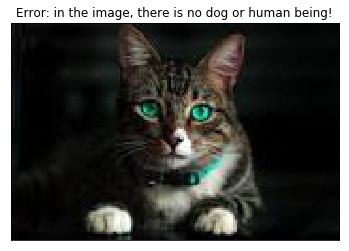

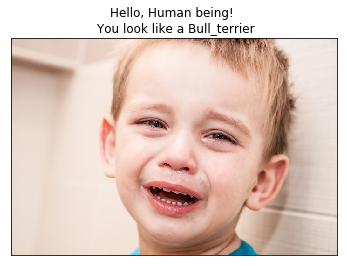

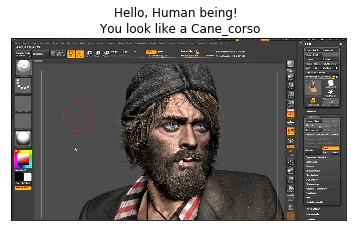

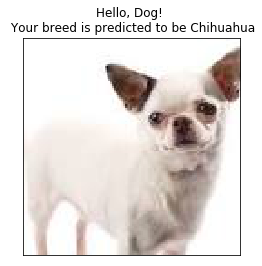

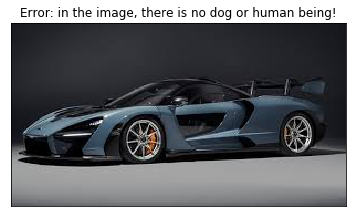

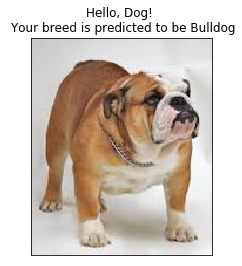

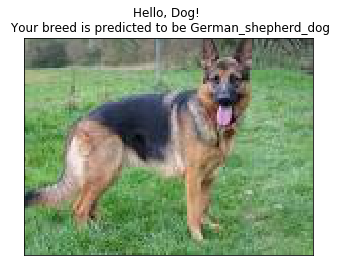

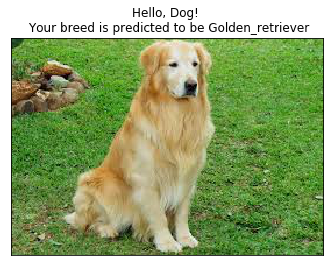

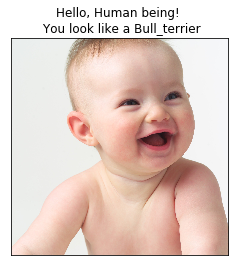

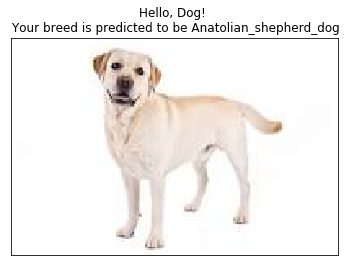

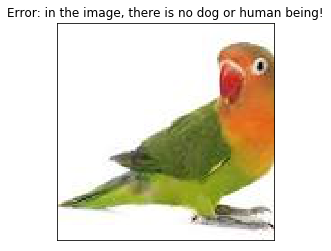

In [32]:
## Test the algorithm with 11 images downloaded from the internet
img_files = glob('./images_to_be_predicted/*')
True_image = []
Dog_breed_predicted = []
for file in img_files:
    true_image = file[25:-4]
    dog_breed, title = breed_detector(file)
    True_image.append(true_image)
    Dog_breed_predicted.append(dog_breed)
    img = cv2.imread(file)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()
    print() 

### True image vs predicted image

In [33]:
import pandas as pd
df = pd.DataFrame({"True Image": True_image, "Prediction": Dog_breed_predicted})
df[['True Image', 'Prediction']]

,True Image,Prediction
0,Cat,Error
1,Crying_boy,Bull_terrier
2,Human_bearded,Cane_corso
3,Chihuahua,Chihuahua
4,Car,Error
5,Bulldog,Bulldog
6,German_shepherd_dog,German_shepherd_dog
7,Golden_Retriever,Golden_retriever
8,Toddler,Bull_terrier
9,Labrodor_retriever,Anatolian_shepherd_dog


---
<a id='step7'></a>
## Conclusion

I have developed an algorithm that could be used as part of a mobile or web app that identifies dog breed in the user supplied image. In this algorithm I used CNN. First I trained a CNN from scratch. Then I used transfer learning technique to create  two CNNs that were built upon pre-trained VGG-16 and ResNet-50 models.
The test accracy was very low at ~13% when I created CNN from scratch. The test accuracy was increased to ~38% when I used VGG-16 and to ~80% when I used ResNet-50 model. Although, test accuracy of ~80% is not sufficient in real life applications, this is better than I expected. In this model only around 270,000 parameters were trained, and model took less than 1 minutes to train. So I believe the performance is reasonable considering the complexity of the problem and limited computational resources used.